In [1]:
%load_ext autoreload
%autoreload 2

import os
import numpy as np
import pandas as pd
from arch import arch_model
import yfinance as yf

from datetime import datetime
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader
from torch.optim import Adam
from torch.optim.lr_scheduler import ExponentialLR
from torch.utils.tensorboard import SummaryWriter
from risk_measures import expected_shortfall

from market_dynamics import garch_generator, bs_generator
from market_dynamics import bs_delta,bs_call_price
from data import SimulationData
from utils import call_payoff, stochastic_integral
from models import ControlNet, BatchNet
from train import train, test
from evaluation import get_eval_data

device = torch.device('cpu')

In [2]:
current_time = datetime.now().strftime('%b%d_%H-%M-%S')
comment = ""
log_dir = os.path.join('experiments', current_time + '_' + comment)
writer = SummaryWriter(log_dir)

In [3]:
ticker = yf.Ticker('^GSPC')
hist = ticker.history(period='1y', start='2013-03-05', end='2018-01-02')
initial_value = hist.Close.iloc[-1]
rets = 100 * hist.Close.pct_change().dropna()
rets.shape

(1217,)

0.11917831633301477

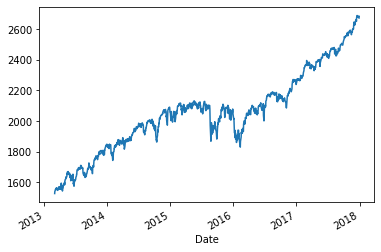

In [4]:
hist.Close.plot()
(rets / 100).std() * (252**0.5)

In [5]:
fit_model = arch_model(rets, p=1, o=1, q=1, dist='t')
res = fit_model.fit(disp='off')
params = res.params

In [6]:
h_params = {"N_SIM": 2 * 10**7,
            "RF": 0,
            "N_DIMS": 2,
            "FC_DIM": 20,
            "LR": 0.0001,
            "GAMMA": 1,
            "EPOCHS": 40,
            "EPOCHS_2": 5, 
            "BATCH_SIZE": 250,}

In [7]:
params

mu          4.937301e-02
omega       2.947883e-02
alpha[1]    1.055132e-11
gamma[1]    3.811128e-01
beta[1]     7.770165e-01
nu          5.719110e+00
Name: params, dtype: float64

In [8]:
strike = np.ceil(initial_value * 1.02)
sigma = (res._volatility[-1] / 100) * (252**0.5)
n_steps = 50
price = bs_call_price(n_steps, initial_value, sigma, h_params["RF"], strike)
initial_value, strike, sigma, price

(2673.610107421875, 2728.0, 0.06413026856822653, 7.0684978380948)

In [9]:
bs_params = {"n_simulations": h_params["N_SIM"],
                  "n_steps": n_steps,
                  "initial_value": initial_value,
                  "sigma": sigma,
                  }

garch_params = {"n_simulations": h_params["N_SIM"],
                "n_steps": n_steps,
                "initial_value": initial_value,
                "params": params,}

price_params = {"n_steps": n_steps,
                "initial_value": initial_value,
                "sigma": sigma,
                "rf": h_params["RF"],
                "strike": strike,
                }

payoff_params = {"strike": strike}

bs_dt = SimulationData(bs_generator, bs_params, lambda x: x, {"x": price}, call_payoff, payoff_params)
dt = SimulationData(garch_generator, garch_params, lambda x: x, {"x": price}, call_payoff, payoff_params, take_log=True)
data_loader_train = DataLoader(dt, batch_size=h_params["BATCH_SIZE"], shuffle=True, pin_memory=True)

In [ ]:
dt.price

Error: Session cannot generate requests

In [ ]:
# Visualizing BS path vs. GJR-GARCH path

j = 100
garch_paths = torch.exp(dt[:j][0].squeeze())
bs_paths = bs_dt[:j][0].squeeze()

plt.plot(garch_paths, c='b');
plt.plot(bs_paths, c='r');

Error: Session cannot generate requests

In [ ]:
# Saving the simulated paths


In [364]:
cn = ControlNet(n_steps, 1, h_params['N_DIMS'] * [h_params["FC_DIM"]], 1, learn_price=False)
#cn = BatchNet(n_steps, 32, 3, batch_norm=True, dropout_p=0.2)

optimizer = Adam(cn.parameters(), lr=h_params["LR"])
scheduler = ExponentialLR(optimizer, gamma=h_params["GAMMA"])
criterion = torch.nn.MSELoss()
metric = torch.nn.L1Loss()

train(data_loader_train, cn, criterion , optimizer, h_params["EPOCHS"], writer, scheduler, device=device, metric=metric)

Epoch 0: : 60batch [00:19,  3.03batch/s, loss=1.18e+3, metric=25.9]
Epoch 1: : 60batch [00:28,  2.12batch/s, loss=956, metric=21.3]
Epoch 2: : 60batch [00:18,  3.32batch/s, loss=3.43e+3, metric=29.3]
Epoch 3: : 60batch [00:20,  2.99batch/s, loss=2.36e+3, metric=27]
Epoch 4: : 60batch [00:15,  3.78batch/s, loss=3.61e+3, metric=31.1]
Epoch 5: : 60batch [00:15,  3.82batch/s, loss=1.18e+3, metric=22.4]
Epoch 6: : 60batch [00:16,  3.72batch/s, loss=857, metric=21.1]
Epoch 7: : 60batch [00:16,  3.67batch/s, loss=1.03e+3, metric=21.9]
Epoch 8: : 60batch [00:16,  3.54batch/s, loss=1.04e+3, metric=23.4]
Epoch 9: : 60batch [00:16,  3.59batch/s, loss=860, metric=20.2]
Epoch 10: : 60batch [00:17,  3.50batch/s, loss=790, metric=18.6]
Epoch 11: : 60batch [00:14,  4.06batch/s, loss=562, metric=16.6]
Epoch 12: : 60batch [00:15,  3.79batch/s, loss=726, metric=17.7]
Epoch 13: : 60batch [00:16,  3.66batch/s, loss=316, metric=13.1]
Epoch 14: : 60batch [00:15,  3.88batch/s, loss=524, metric=15]
Epoch 15: :

In [244]:
x, x_inc, payoff, price = next(iter(data_loader_train))

In [251]:
x.shape

torch.Size([250, 50, 1])

<AxesSubplot:>

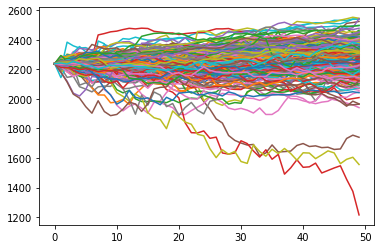

In [253]:
pd.DataFrame(x.squeeze().T.numpy()).plot(legend=False)

In [ ]:

# Model
cn.eval_mode()

hedge = cn(x)
si = stochastic_integral(x_inc, hedge)

ml_mkt_price = (price + si - payoff) ** 2
#ml_learned_price = (learned_price + si - payoff) ** 2

# Delta hedge benchmark
def delta(x):
    return bs_delta(n_steps, x, sigma, h_params["RF"], strike)

d_hedge = torch.Tensor([delta(i) for i in x.squeeze().detach().cpu().numpy()])
si = stochastic_integral(x_inc.cpu(), d_hedge)
dl_mkt_price = (price + si - payoff) ** 2
#dl_learned_price = (learned_price + si - payoff) ** 2

<AxesSubplot:xlabel='Date'>

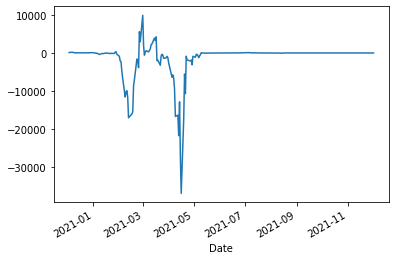

In [176]:
(100 * (np.cumprod(1 + hist))).plot()

In [177]:
res = garch_generator(3, 100, 100, params)

In [178]:
res.shape

(3, 101)

<AxesSubplot:>

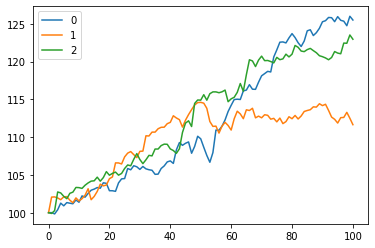

In [179]:
pd.DataFrame(res.T).plot()